# Notebook to visualize simulated Alpine-3D grids
## First, import packages

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import glob
import urllib.request
import moviepy.editor as mpy
from palettable.colorbrewer.sequential import *
from palettable.colorbrewer.diverging import *

## Download file from dropbox and plot

--2020-07-23 14:20:35--  https://www.dropbox.com/s/l035enj35bsxsd6/a3d_grids.nc?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/l035enj35bsxsd6/a3d_grids.nc [following]
--2020-07-23 14:20:35--  https://www.dropbox.com/s/raw/l035enj35bsxsd6/a3d_grids.nc
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc6477888e60cde4fcdef1488dd.dl.dropboxusercontent.com/cd/0/inline/A8GU0-0pKI-CnnxDXXOxpmwjvT42j3kMk7c7Kn3JHQchr0_LWt5ebSBFh3pnZAxs7FrLbCapyjYx2i77ApdchwDtyqxbUrALZ6kAaZILKygtCZjI3ep2ELf03S1LBFhUr_s/file# [following]
--2020-07-23 14:20:35--  https://ucc6477888e60cde4fcdef1488dd.dl.dropboxusercontent.com/cd/0/inline/A8GU0-0pKI-CnnxDXXOxpmwjvT42j3kMk7c7Kn3JHQchr0_LWt5ebSBFh3pnZAxs7FrLbCapyjYx2i77ApdchwDtyqxbUrALZ6kAaZILKygtC

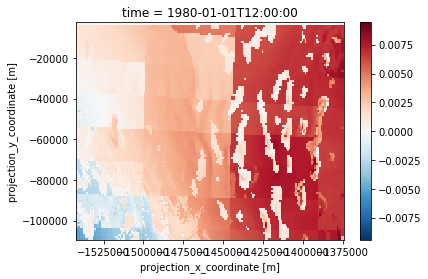

In [5]:
!wget -O a3d_grids.nc https://www.dropbox.com/s/l035enj35bsxsd6/a3d_grids.nc?dl=0
file_name="a3d_grids.nc"
ds = xr.open_dataset(file_name)
SMB = ds['pr'] - ds['SFC_SUBL'] - ds['MS_SNOWPACK_RUNOFF']
SMB = SMB.cumsum(dim='time')
SMB[-1,:,:].plot()

In [14]:
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 1)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T12:00:00
  * northing               (northing) float32 -109000.0 -108000.0 ... -3000.0
  * easting                (easting) float32 -1542000.0 ... -1375000.0
Data variables:
    dw                     (time, northing, easting) float32 288.49902 ... nan
    snd                    (time, northing, easting) float32 9.070597 ... nan
    rlds                   (time, northing, easting) float32 191.68224 ... nan
    rsds                   (time, northing, easting) float32 367.4586 ... nan
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 0.0 0.0 ... nan nan
    pr                     (time, northing, easting) float32 0.00019742099 ... nan
    snow_density           (time, northing, easting) float32 466.5282 ... nan
    SFC_SUBL               (time, northing, easting) float32 0.0052302447 ... nan
    swe                    (time, northing, easting) float32 4231.689 ... nan
    ta                     (time, northing, easting) float32 253.95058 ... nan
    ts                     (time, northing, easting) float32 254.1454 ... nan
    ws                     (time, northing, easting) float32 21.803133 ... nan
    VW_DRIFT               (time, northing, easting) float32 21.803133 ... nan
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 -0.0 -0.0 ... nan
Attributes:
    date_created:              2020-07-17
    creator_name:              erke2265
    source:                    MeteoIO-2.81
    history:                   2020-07-17T23:46:22Z, erke2265@shas0240.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1542000.0000000000 -109000.00000000...

## Add netCDF file path, define grid variable to plot, and time step.

In [2]:
nc_path = "../output/grids/a3d_grids.nc"
ds = xr.open_dataset(nc_path)
tgt_time = "1980-01-01T12:00:00" # Specific timestep
tgt_time_ind = -1 # Last timestep

'''
Surface Mass Balance:
Precip - sublimation - runoff - net wind erosion
Precip units: kg/m2/s
time step = 12 hours = 60 * 60 * 12 seconds = 43200 seconds
'''
time_step = 60 * 60 * 12 # seconds
SMB = ds['pr'] * time_step - ds['SFC_SUBL'] - ds['MS_SNOWPACK_RUNOFF'] # Does this includ wind erosion???
SMB = SMB.cumsum(dim='time')
SMB

<xarray.DataArray (time: 2421, northing: 4, easting: 6)>
array([[[-2.58265209e-04,  2.01015454e-03,  3.52346082e-03,
          6.34767581e-03,  1.22105591e-02,  1.26642957e-02],
        [-3.67657654e-03, -9.81337973e-04,  6.82107639e-03,
          1.24060614e-02,  1.33571718e-02,  1.29033979e-02],
        [-4.29440930e-04,  3.80845158e-03,  7.05852034e-03,
          8.96453019e-03,  1.06572947e-02,  1.25193400e-02],
        [-7.40899146e-03,  6.14297204e-03,  8.68843496e-03,
          6.66564610e-03,  8.61448888e-03,  1.11090383e-02]],

       [[ 3.05996437e+01,  3.18211079e+01,  3.30762978e+01,
          3.37375793e+01,  3.35949821e+01,  3.30738335e+01],
        [ 3.30842056e+01,  3.52866058e+01,  3.75361099e+01,
          3.86922226e+01,  3.83695564e+01,  3.70053368e+01],
        [ 3.71684608e+01,  4.07813148e+01,  4.44633179e+01,
          4.63002052e+01,  4.57941360e+01,  4.30701370e+01],
        [ 4.26594315e+01,  4.78595428e+01,  5.30137062e+01,
          5.54422798e+01,  5.45907440e+01,  5.02419891e+01]],

       [[ 7.08650055e+01,  7.35778656e+01,  7.63346786e+01,
          7.77108078e+01,  7.73527374e+01,  7.63774414e+01],
        [ 7.66585083e+01,  8.15627441e+01,  8.64629059e+01,
          8.87833710e+01,  8.79295120e+01,  8.52244415e+01],
        [ 8.62159576e+01,  9.42140961e+01,  1.02114365e+02,
          1.05719101e+02,  1.04392746e+02,  9.90603333e+01],
        [ 9.90205688e+01,  1.10425888e+02,  1.21281433e+02,
          1.25996368e+02,  1.24067551e+02,  1.15964325e+02]],

       ...,

       [[ 3.77080775e+06,  3.69839925e+06,  3.59240050e+06,
          3.46951100e+06,  3.34387550e+06,  3.24344925e+06],
        [ 3.73868750e+06,  3.65822750e+06,  3.54393525e+06,
          3.41288600e+06,  3.28079625e+06,  3.17711675e+06],
        [ 3.68673300e+06,  3.60003775e+06,  3.48059900e+06,
          3.34692025e+06,  3.21457550e+06,  3.11150525e+06],
        [ 3.62821575e+06,  3.53939025e+06,  3.42008650e+06,
          3.28831325e+06,  3.15851750e+06,  3.05725525e+06]],

       [[ 3.77121775e+06,  3.69874000e+06,  3.59269025e+06,
          3.46976800e+06,  3.34411300e+06,  3.24367575e+06],
        [ 3.73908525e+06,  3.65855550e+06,  3.54421175e+06,
          3.41312850e+06,  3.28101775e+06,  3.17732650e+06],
        [ 3.68711975e+06,  3.60035475e+06,  3.48086500e+06,
          3.34715225e+06,  3.21478525e+06,  3.11170250e+06],
        [ 3.62859725e+06,  3.53970100e+06,  3.42034625e+06,
          3.28853875e+06,  3.15872025e+06,  3.05744475e+06]],

       [[ 3.77168425e+06,  3.69913700e+06,  3.59303825e+06,
          3.47008775e+06,  3.34441850e+06,  3.24397050e+06],
        [ 3.73953150e+06,  3.65893350e+06,  3.54454125e+06,
          3.41342950e+06,  3.28130275e+06,  3.17759950e+06],
        [ 3.68754525e+06,  3.60071375e+06,  3.48117700e+06,
          3.34743550e+06,  3.21505100e+06,  3.11195575e+06],
        [ 3.62900775e+06,  3.54004550e+06,  3.42064500e+06,
          3.28880825e+06,  3.15897100e+06,  3.05768275e+06]]],
      dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-04-10T21:00:00
  * northing  (northing) float32 -122000.0 -92000.0 -62000.0 -32000.0
  * easting   (easting) float32 -1542000.0 -1512000.0 ... -1422000.0 -1392000.0

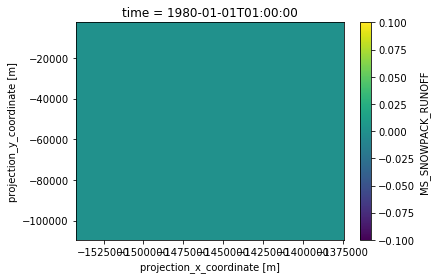

In [3]:
# tmp = time_step * ds['pr'][0,:,:]
# tmp = time_step * ds['SFC_SUBL'][0,:,:]
tmp = time_step * ds['MS_SNOWPACK_RUNOFF'][0,:,:]
tmp.plot()

## Load coastlines data

In [3]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

## Plot grid

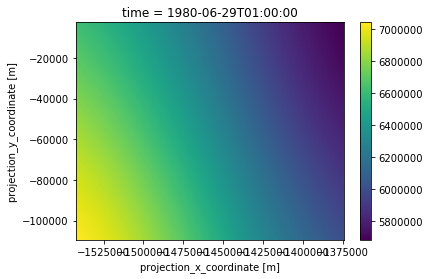

In [5]:
# Plot on specific day
# ds.sel(time=tgt_time)[var_plot].plot()

# Plot last timestep
SMB.isel(time=tgt_time_ind).plot()

## Plot map

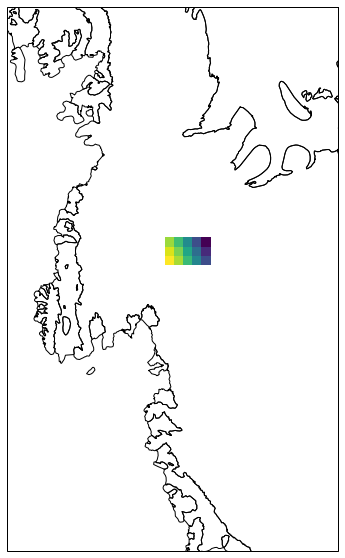

In [12]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
# axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree()) # Full ice sheet
# axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree()) # Zoom in even more on Alpine-3D domain
axs.set_extent((-120, -70, -80, -71), ccrs.PlateCarree()) # Zoom in on Alpine-3D domain


axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Define easting and northings
northings = ds.sel(time=tgt_time)['northing']
eastings = ds.sel(time=tgt_time)['easting']

# Plot map
mesh = plt.pcolormesh(eastings, northings, SMB.isel(time=tgt_time_ind))
plt.savefig('A3D_Domain_Map.pdf', format='pdf', dpi=100)

# Make a movie of SWE and SMB

In [8]:
# # Settings
# var = 'swe'
# fps = 30
# file_name = "movie"

# # Clear old images, gifs, and movies
# !mkdir -p movie_frame
# !rm -f movie.gif
# !rm -f movie.mp4

# # Calculate colorbar limits
# diff_magnitude = np.abs(ds[var] - ds.isel(time=0)[var])
# diff_lim = diff_magnitude.max()
# lim = ds[var].max()

# for j in range(0, len(ds['time']), 2):
# # for j in range(0, 2):
    
#     # Figure settings
#     fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
#     time = str(ds['time'][j].values)
    
#     # SWE
#     swe = ax1.pcolormesh(eastings/1000, northings/1000, ds.isel(time=j)[var], \
#                          cmap=Blues_9.mpl_colormap, vmin=0, vmax=lim)
#     fig1.colorbar(swe, ax=ax1)
#     ax1.set_title("SWE [mm]: " + time[0:10])
    
#     # Change in SWE
#     dswe = ax2.pcolormesh(eastings/1000, northings/1000, \
#                           ds.isel(time=j)[var] - ds.isel(time=0)[var], \
#                           cmap=RdBu_11.mpl_colormap, \
#                           vmin=-diff_lim, vmax=diff_lim)
    
#     fig1.colorbar(dswe, ax=ax2)
#     ax2.set_title("Accumulated SMB [mm]: " + time[0:10])
    
#     #Save Figure with image number zero padding 
#     if j < 10:
#         plt.savefig("movie_frame/frame_00" + str(j) + ".png", dpi=100)
#     elif j < 100 and j > 9:
#         plt.savefig("movie_frame/frame_0" + str(j) + ".png", dpi=100)
#     else:
#         plt.savefig("movie_frame/frame_" + str(j) + ".png", dpi=100)
#     plt.close()
    
# # Make a .mp4 movie and gif
# file_list = sorted(glob.glob('movie_frame/*.png'))
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_videofile(file_name+'.mp4')
# clip.write_gif(file_name+'.gif')

# # Clear images
# !rm -rf movie_frame

## Plot timeseries of integrated SMB

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([214692.03, 214692.12, 214692.23, 214692.33, 214692.44, 214692.53,
        214692.62, 214692.73, 214692.83, 214692.94, 214693.03],
       dtype=float32),
 <a list of 10 Patch objects>)

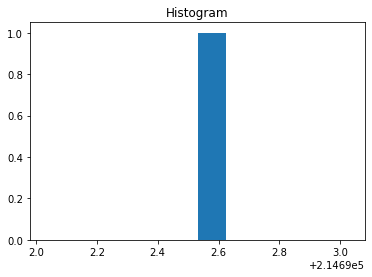

In [9]:
SMB_t = SMB.sum(dim='northing').sum(dim='easting')
SMB_t.plot()

In [12]:
SMB

<xarray.DataArray (time: 1, northing: 107, easting: 168)>
array([[[ 8.523356 ,  6.672721 ,  5.5403137, ..., 73.66186  ,
         70.910446 , 48.298283 ],
        [ 8.516814 ,  6.4711103,  4.0915585, ..., 71.2206   ,
         63.447887 , 45.41784  ],
        [ 8.514674 ,  4.6757817,  5.146557 , ..., 66.12955  ,
         53.662292 , 41.56237  ],
        ...,
        [10.692512 ,  8.950523 ,  8.976767 , ..., 10.509863 ,
         11.189064 , 11.508143 ],
        [10.715304 ,  9.13993  ,  8.560611 , ..., 10.134004 ,
         11.109069 , 11.6110325],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01T12:00:00
  * northing  (northing) float32 -109000.0 -108000.0 ... -4000.0 -3000.0
  * easting   (easting) float32 -1542000.0 -1541000.0 ... -1376000.0 -1375000.0